#### 작성자 : 계윤우


## 1. 주제 : 어떤 주식을 사야 미래에 오를까?
## 2. 목표 : 내가 고른 주식의 데이터를 넣었을 때, 해당 주식이 미래에 코스피 지수보다 더 오를지, 덜 오를지 '분류'하는 모델 만들기
- 모델 종류 : 이진 분류
- Target
    - 0 : 고른 종목(데이터)이 6개월 뒤 KOSPI보다 낮은 수익률을 보였다.
    - 1 : 고른 종목이 6개월 뒤 KOSPI보다 높은 수익률을 보였다.
    
    
## 3. 데이터
- 분석 종목 : 2003년 기준 시가총액 상위 400위 기업(데이터 누수를 피하기 위해 현재 기준으로 하지 않음)
- 종류  
    1) 시가총액 데이터 : 한국거래소  
    2) 주가 변동 데이터 : 2003년 ~ 현재, `FinanceDataReader` 라이브러리 사용  
    3) 종목에 따른 연도별 PER, PBR, 배당수익률 데이터 : 한국거래소
    
## 4. Feature
- 미래의 주가에 영향을 끼칠 것이라 예상되는 것들로 선정
- 종류  
    1) 12개월 간 수익률 : 최근 12개월 간 수익률이 얼마나 났는가 (float)  
    2) KOSPI대비 12개월 간 수익률 : 최근 12개월 간 KOSPI 대비 수익률이 얼마나 났는가 (float)  
    3) 12개월 간 KOSPI 이김 : 최근 12개월 간 KOSPI 대비 수익률이 높았는가 (binary)  
    4) PER_inv : 해당 종목, 해당 시점의 PER의 역수 (float)  
    5) PBR_inv : 해당 종목, 해당 시점의 PBR의 역수 (float)  
    6) 배당수익률 : 주주에게 배분된 배당금과 주주가 갖고 있는 주식 가치의 비 (float)
   
    
 (* PER, PBR은 시가총액과 당기순이익, 자본의 비이며 낮을 수록 저평가된 기업으로 여겨짐)
 
 
 ## 5. 가설
 - Feature와 Target 사이에는 시간에 독립적인 관계가 있다.
 - 따라서 시간에 관계 없이 종목의 feature, target 데이터만 있으면 모델을 학습시키고, 결과를 예측할 수 있다.

# 1. 데이터 수집
- 2003년 기준 시가총액 상위 400 종목

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import FinanceDataReader as fdr
# import dart_fss as dart
import warnings
import eli5
from eli5.sklearn import PermutationImportance
from datetime import datetime, timedelta
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import f1_score, plot_confusion_matrix, roc_curve, roc_auc_score, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

warnings.filterwarnings(action='ignore')
%matplotlib inline
mpl.rc("font", family='Malgun Gothic')
plt.style.use('ggplot')
# pd.options.display.max_rows = 500

In [3]:
# 2003년부터 PER, PBR이 기입돼 있어서 2003년부터
date_list = ['20030102', '20040102', '20050102', '20060102', '20070102', '20080102', '20090102'
             , '20110102', '20120102', '20130102', '20140102', '20150102'
             , '20160102', '20170102', '20180102', '20190102', '20200102']

date_list_for_PER = date_list + ['20210102']

date_start = date_list[0]

N = 600 # 시가총액 상위 N 종목

df = pd.read_csv('./data/{}_total_stock.csv'.format(date_start), encoding='euc-kr')

# 시가총액 상위 N종목 코드 리스트
top_code = df.sort_values(by='시가총액', ascending=False).head(N).종목코드.to_list()

# 종목코드를 가지고 종목명을 찾을 수 있는 dictionary
code_to_name_dic = df[['종목코드', '종목명']].set_index('종목코드').to_dict()['종목명']

KOSPI = fdr.DataReader('KS11', date_start)

# 종목코드별 주가 데이터 dictionary에 저장
stock_price_dic = {}
for code in top_code:
    stock_price_dic[code] = fdr.DataReader(code, date_start)

# 2. 데이터 가공하기 및 엔지니어링

In [4]:
def date_add(date, month):
    '''date에 month만큼 더해준다. date는 20210102와 같은 꼴이나 datetime type으로 입력한다.'''
    if type(date) == str: # date가 datetime이 아니라 str 타입으로 들어온 경우
        date = datetime.strptime(date, '%Y%m%d')
    delta = timedelta(days=month*30.5)
    return date + delta

print('date_add 함수 테스트 : {}'.format(date_add(date_start, 12)))


def earning_rate(stock_price : list, start_date, end_date):
    '''start_date부터 end_date까지 stock_price데이터를 가지고 수익률을 구해주는 함수(종가 기준)'''
    possible_start_date = stock_price[stock_price.index >= start_date].index[0]
    possible_end_date = stock_price[stock_price.index <= end_date].index[-1]
    
    start_price = stock_price.loc[possible_start_date].Close
    end_price = stock_price.loc[possible_end_date].Close
    
    return (end_price - start_price) / start_price
    
sample_stock_price = stock_price_dic[top_code[0]]

print('수익률 함수 테스트 : {:.4f}%'.format(earning_rate(sample_stock_price, '20170101', '20170603')*100))


def plot_stock(stock_price_dic : dict, code : str) -> None :
    '''stock_price_dic과 종목 code를 받으면 주가 변동을 그려주는 함수(종가 기준)'''
    plt.plot(stock_price_dic[code].Close)
    plt.xlabel('date')
    plt.ylabel('원')
    plt.title(code_to_name_dic[code])

date_add 함수 테스트 : 2004-01-03 00:00:00
수익률 함수 테스트 : 27.3130%


1위


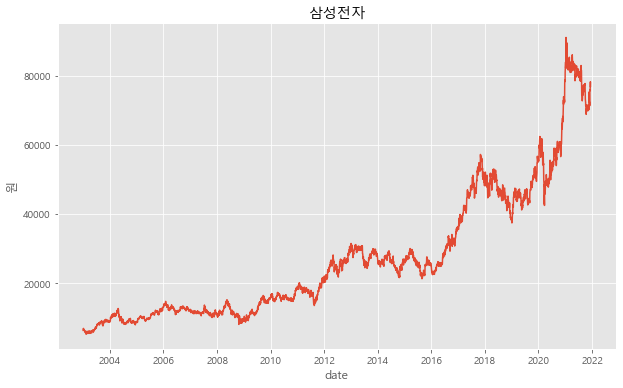

2위


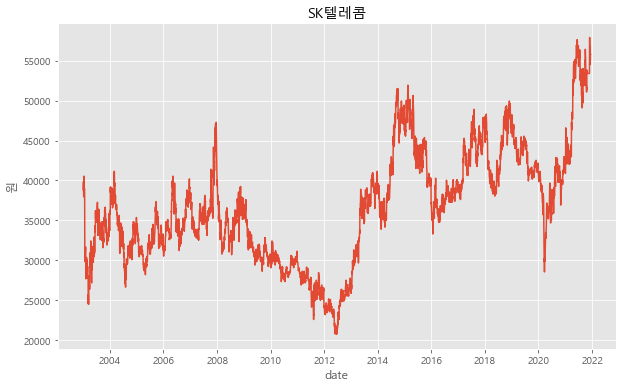

3위


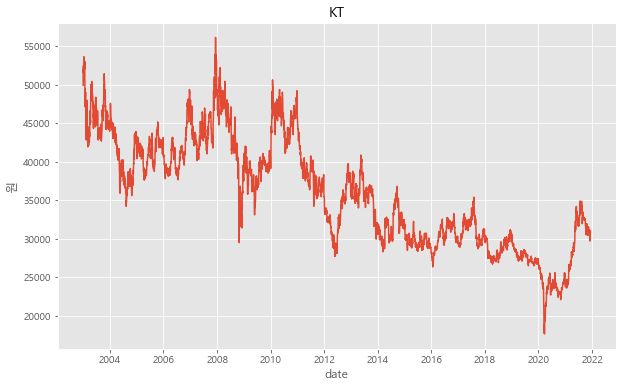

4위


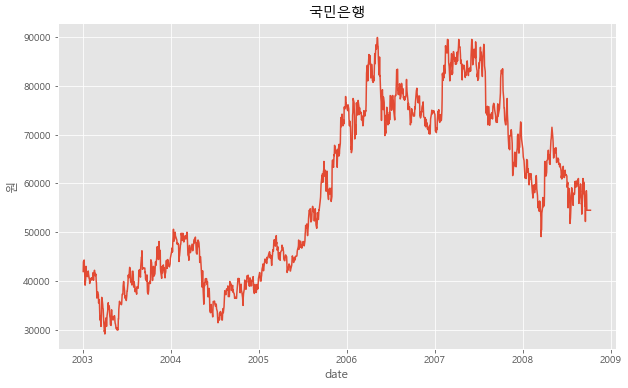

5위


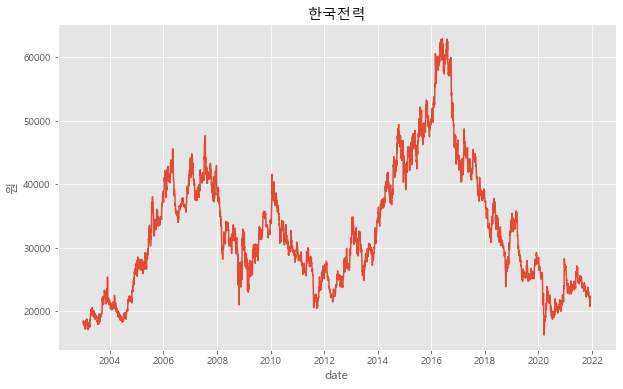

In [5]:
for i, code in enumerate(top_code[:5]):
    plt.figure(figsize=(10,6))
    plot_stock(stock_price_dic, code)
    print('{}위'.format(i+1))
    plt.show()

In [6]:
stock_price = stock_price_dic[top_code[0]]
stock_price.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2003-01-02,6380,6460,6300,6430,511660,0.023885
2003-01-03,6700,7000,6640,6880,1110675,0.069984
2003-01-06,6940,7030,6879,6990,499437,0.015988
2003-01-07,7180,7180,6840,6850,577944,-0.020029
2003-01-08,6920,6930,6770,6800,504232,-0.007299


In [7]:
n = 12 # n개월 간의 주가 추이 확인
m = 6 # m개월 후의 수익률 확인

def ER_list_return(stock_price, n=n, m=m, date_list=date_list):
    '''stock_price정보를 가지고 base_date 기준 n개월 전, m개월 후 수익률(Earning Rate)을 구해준다.
    return : 데이터로 사용할 수익률, target을 구할 때 사용할 수익률, base_date'''
    earning_rate_list = []
    target_list = []
    base_date_list = []  # 수익률 기준일
    
    periods = 12//n # n = 2개월이면 12개월을 6개로 쪼개는 식
    for date in date_list:
        try:
            for period in range(periods): 
                date_start = date_add(date, period*n)
                date_end = date_add(date_start, n)
                
                ER_before = earning_rate(stock_price, date_start, date_end)
                ER_after = earning_rate(stock_price, date_end, date_add(date_end, m))
                
                earning_rate_list.append(ER_before)
                target_list.append(ER_after)
                base_date_list.append(date_end)
                
        except: # 종목코드가 바뀌거나 상장폐지돼서 주가 데이터가 없는 경우가 있는 것 같음. 이를 고려             
            break

    return earning_rate_list, target_list, base_date_list


# DataFrame 만들기 위해 모든 종목들에 대해 시행해주기
n_month_ER_data = []
m_month_ER_data = []
date_data = []
code_data = []

for code in top_code:
    stock_price = stock_price_dic[code]
    earning_rate_list, target_list, base_date_list = ER_list_return(stock_price)
    n_month_ER_data += earning_rate_list
    m_month_ER_data += target_list
    date_data += base_date_list
    code_data += [code]*len(base_date_list)

In [8]:
data = pd.DataFrame({
                     'date' : date_data,
                     'code' : code_data,
                     f'{n}개월 간 수익률': n_month_ER_data,
                     f'{m}개월 후 수익률' : m_month_ER_data
                    })

data['name'] = data.code.apply(lambda x: code_to_name_dic[x])

KOSPI_n_earning, KOSPI_m_earning, KOSPI_base_date = ER_list_return(KOSPI)

KOSPI_data = pd.DataFrame({
                     'date' : KOSPI_base_date,
                     f'KOSPI {n}개월 간 수익률': KOSPI_n_earning,
                     f'KOSPI {m}개월 후 수익률' : KOSPI_m_earning
                    })

data = data.merge(KOSPI_data, on='date')

# KOSPI 대비 수입률 Feature 만들기
data[f'KOSPI대비 {n}개월 간 수익률'] = data[f'{n}개월 간 수익률'] - data[f'KOSPI {n}개월 간 수익률']
data[f'KOSPI대비 {m}개월 후 수익률'] = data[f'{m}개월 후 수익률'] - data[f'KOSPI {m}개월 후 수익률']
data[f'{n}개월 간 KOSPI 이김'] = data[f'KOSPI대비 {n}개월 간 수익률'].apply(lambda x: 1 if x>=0 else 0)
data[f'KOSPI보다 많이 오름'] = data[f'KOSPI대비 {m}개월 후 수익률'].apply(lambda x: 1 if x>=0 else 0)



# PER 파일 불러와서 dic에 저장
df_PER_dic = {}
for date in date_list_for_PER:
    # 결측치는 0으로
    df_PER_dic[date] = pd.read_csv('./data/{}_PER_PBR.csv'.format(date), encoding='euc-kr')
    df_PER_dic[date][['PER', 'PBR']] = df_PER_dic[date][['PER', 'PBR']].fillna(10000)
    df_PER_dic[date][['배당수익률']] = df_PER_dic[date][['배당수익률']].fillna(0)

def near_date_for_PER(date, date_list=date_list_for_PER):
    '''한국거래소에서 받은 PER를 데이터 누수(미래의 PER 사용;) 없이 사용하기 위해 date에 따라 적절한 사용가능 날짜를 date_list에서 뽑아 리턴.
    date는 datetime 타입'''
    for d in date_list:
        d = datetime.strptime(d, '%Y%m%d')
        if d - timedelta(days=30) <= date < d + timedelta(days=336):
            return d.strftime('%Y%m%d')
    return date_list[0]

# near_date_for_PER(data.date[0])

def search_for_PER(code, date):
    '''code와 date 조건에 맞는 데이터를 PER가 담긴 df에서 찾아줌'''
    if type(date) != str:
        date = near_date_for_PER(date)
    df = df_PER_dic[date]
    cond = df['종목코드'] == code
    
    if cond.sum() == 0:
        fake_data = [0] * len(df.columns)
        return pd.DataFrame([fake_data], columns=df.columns)
    return df[cond]

# search_for_PER('069117', '20110102')

temp_df_list = []
for date, code in zip(data.date, data.code):
    temp_df_list.append(search_for_PER(code, date))
data_PER = pd.concat(temp_df_list, ignore_index=True)

data = pd.concat([ data, data_PER[['PER', 'PBR', '배당수익률']] ], axis=1)
data['PER_inv'] = 1/data['PER']
data['PBR_inv'] = 1/data['PBR']

data.head(3)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
0,2004-01-03,005930,0.396579,-0.029508,삼성전자,0.292977,-0.083339,0.103602,0.053831,1,1,10.69,2.83,1.22,0.093545,0.353357
1,2004-01-03,017670,-0.066665,-0.122311,SK텔레콤,0.292977,-0.083339,-0.359642,-0.038971,0,0,11.71,2.14,0.86,0.085397,0.467290
2,2004-01-03,030200,-0.092184,-0.166667,KT,0.292977,-0.083339,-0.385161,-0.083327,0,0,5.98,1.01,1.90,0.167224,0.990099


In [9]:
data.shape

(8267, 16)

# 3. 모델링 및 예측

In [10]:
features = [f'{n}개월 간 수익률', f'KOSPI대비 {n}개월 간 수익률', f'{n}개월 간 KOSPI 이김', 'PER_inv', 'PBR_inv', '배당수익률']
targets = ['3개월 후 수익률', 'KOSPI대비 3개월 후 수익률', 'KOSPI보다 많이 오름'] # 얘네들을 feature에 넣으면 Data leakage가 발생하게 됨
target = ['KOSPI보다 많이 오름']

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# basline model 정의
target_mode = y_train['KOSPI보다 많이 오름'].value_counts(normalize=True).sort_values(ascending=False).index[0]
baseline_model = [1] * len(y_test) # precision check를 위해 baseline model은 1로

In [11]:
# Logistic Regression을 이용한 모델
pipe = make_pipeline(
#               OrdinalEncoder()
#             , SimpleImputer(strategy='mean')
            LogisticRegression()
            )
pipe.fit(X_train.values, y_train.values.ravel());
y_pred = pipe.predict(X_test.values)
y_proba = pipe.predict_proba(X_test.values)[:, 1]

threshold = 0.65
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(pipe, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Baseline model Precision score : 0.4903
Model Cross Vlidation Precision score : 0.5299
Model Precision score(Test set) : 0.5419
Threshold adjusted Model Precision score : 0.5500
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 27.37%


In [12]:
# 모델이 코스피보다 높은 수익률을 보일 것이라 예측한 데이터
data.loc[X_test[y_proba > threshold].index].sort_values(by='date').tail(5)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
3935,2012-01-03,002410,-0.710932,-0.628975,범양건영,-0.094040,-0.000512,-0.616892,-0.628463,0,0,5.43,0.08,0.00,0.184162,12.500000
4430,2013-01-02,037950,-0.802813,0.167896,한성엘컴텍,0.112097,-0.094510,-0.914909,0.262406,0,1,10000.00,0.11,0.00,0.000100,9.090909
4935,2014-01-03,000800,-0.332707,0.152113,경남기업,-0.041830,0.032639,-0.290877,0.119474,0,1,0.76,0.13,0.00,1.315789,7.692308
4880,2014-01-03,011810,-0.691194,-0.284882,STX,-0.041830,0.032639,-0.649365,-0.317521,0,0,10000.00,0.14,4.74,0.000100,7.142857
7237,2019-01-03,000950,-0.124675,0.014837,전방,-0.195975,0.058630,0.071300,-0.043793,1,0,10000.00,0.19,2.95,0.000100,5.263158


In [13]:
# Random Forest를 이용한 모델
pipe = make_pipeline(
#               OrdinalEncoder()
#             , SimpleImputer(strategy='mean')
            RandomForestClassifier(n_estimators=150, min_samples_leaf=2, random_state=10
                                     , oob_score=True, n_jobs=-1)
            )
pipe.fit(X_train.values, y_train.values.ravel());
y_pred = pipe.predict(X_test.values)
y_proba = pipe.predict_proba(X_test.values)[:, 1]

threshold = 0.65
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(pipe, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 : {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Baseline model Precision score : 0.4903
Model Cross Vlidation Precision score : 0.5153
Model Precision score(Test set) : 0.5406
Threshold adjusted Model Precision score : 0.5873
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 : 22.92%


In [14]:
# 모델이 코스피보다 높은 수익률을 보일 것이라 예측한 데이터
data.loc[X_test[y_proba > threshold].index].sort_values(by='date').tail()

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
7901,2021-01-02,004800,0.001311,0.399204,효성,0.321032,0.114565,-0.319722,0.284640,0,1,14.78,0.65,6.63,0.067659,1.538462
7835,2021-01-02,030200,-0.101124,0.336134,KT,0.321032,0.114565,-0.422156,0.221570,0,1,9.42,0.45,4.62,0.106157,2.222222
7923,2021-01-02,004150,-0.108396,0.274216,한솔제지,0.321032,0.114565,-0.429428,0.159651,0,1,6.09,0.40,0.00,0.164204,2.500000
8174,2021-01-02,058650,-0.032870,0.363636,세아홀딩스,0.321032,0.114565,-0.353902,0.249072,0,1,9.99,0.16,2.92,0.100100,6.250000
8210,2021-01-02,031980,-0.038239,0.505313,피에스케이,0.321032,0.114565,-0.359271,0.390748,0,1,8.92,0.53,1.77,0.112108,1.886792


# Grid SearchCV 를| 통한 하이퍼 파라미터 튜닝

In [15]:
# GridSearchCV

pipe = make_pipeline(
            RandomForestClassifier(random_state=10, oob_score=True, n_jobs=-1)
            )

dists = {
    'randomforestclassifier__n_estimators' : [150, 300, 600],
    'randomforestclassifier__min_samples_leaf' : [2, 3, 4],
}

clf = GridSearchCV(
    pipe,
    param_grid=dists,
    cv=3,
    scoring='precision',
    verbose=1,
    n_jobs=-1    
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [16]:
print('Optimized Hyper parameters : {}'.format(clf.best_params_))
print('Best precision score : {}'.format(clf.best_score_))

best_model = clf.best_estimator_

y_pred = best_model.predict(X_test.values)
y_proba = best_model.predict_proba(X_test.values)[:, 1]

threshold = 0.65
y_pred_thres = np.array(list(map(lambda x: 0 if x < threshold else 1, y_proba)))

print()
print('Baseline model Precision score : {:.4f}'.format(precision_score(y_test, baseline_model)))
print('Model Cross Vlidation Precision score : {:.4f}'.format(cross_val_score(best_model, X.values, y.values.ravel(), cv=5, scoring='precision').mean()))
print('Model Precision score(Test set) : {:.4f}'.format(precision_score(y_test, y_pred)))
print('Threshold adjusted Model Precision score : {:.4f}'.format(precision_score(y_test, y_pred_thres)))
print('만약 threshold값 이상의 종목을 사고 {}개월 뒤 판매했다면? 기대 수익률 : {:.2f}%'.format(m, data.loc[X_test[y_proba > threshold].index][f'{m}개월 후 수익률'].mean()*100))

Optimized Hyper parameters : {'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 600}
Best precision score : 0.552744642355294

Baseline model Precision score : 0.4903
Model Cross Vlidation Precision score : 0.5171
Model Precision score(Test set) : 0.5377
Threshold adjusted Model Precision score : 0.6318
만약 threshold값 이상의 종목을 사고 6개월 뒤 판매했다면? 기대 수익률 : 24.90%


In [17]:
# 모델이 코스피보다 높은 수익률을 보일 것이라 예측한 데이터
data.loc[X_test[y_proba > threshold].index].sort_values(by='date').tail(5)

,date,code,12개월 간 수익률,6개월 후 수익률,name,KOSPI 12개월 간 수익률,KOSPI 6개월 후 수익률,KOSPI대비 12개월 간 수익률,KOSPI대비 6개월 후 수익률,12개월 간 KOSPI 이김,KOSPI보다 많이 오름,PER,PBR,배당수익률,PER_inv,PBR_inv
7895,2021-01-02,000700,-0.128983,0.259717,한진해운,0.321032,0.114565,-0.450016,0.145153,0,1,34.72,0.65,0.00,0.028802,1.538462
8146,2021-01-02,007330,0.072539,0.943765,푸른저축은행,0.321032,0.114565,-0.248494,0.829201,0,1,4.07,0.46,6.72,0.245700,2.173913
7911,2021-01-02,000240,0.046429,0.388889,한국타이어,0.321032,0.114565,-0.274604,0.274324,0,1,8.73,0.41,2.43,0.114548,2.439024
7854,2021-01-02,005940,-0.096000,0.133929,LG투자증권,0.321032,0.114565,-0.417032,0.019364,0,1,7.07,0.62,4.46,0.141443,1.612903
8237,2021-01-02,006660,-0.105328,2.392130,삼성공조,0.321032,0.114565,-0.426361,2.277566,0,1,12.43,0.28,0.81,0.080451,3.571429


# 4. 어떤 Feature가 어떤 역할을 했을까?(모델 분석)

## 1) Permutation Importance

In [18]:
# permuter 정의
permuter = PermutationImportance(
    best_model, # model
    scoring='precision', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_train, y_train);

feature_names = X_train.columns.tolist()
# pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.2791 ± 0.0037,PBR_inv
0.2181 ± 0.0077,12개월 간 수익률
0.2100 ± 0.0086,KOSPI대비 12개월 간 수익률
0.1975 ± 0.0046,PER_inv
0.1940 ± 0.0089,배당수익률
0.0163 ± 0.0021,12개월 간 KOSPI 이김


## 2) PDP plot

In [21]:
from pdpbox.pdp import pdp_isolate, pdp_plot

for feat in X_train.columns[[0, 1, 3, 4, 5]]:
    feature = feat
    isolated = pdp_isolate(
        model=best_model,
        dataset=X_test,
        model_features=X_test.columns,
        feature = feature,
        grid_type='percentile', # 다른 option으로 'equal'이 있음
        num_grid_points=70,
    )
    print('{} PDP'.format(feat))
    plt.figure();
    pdp_plot(isolated, feature_name=feature, plot_lines=True, plot_pts_dist=True);
    plt.show();

ModuleNotFoundError: No module named 'pdpbox'

## 3) SHAP Values

In [22]:
import shap

explainer = shap.TreeExplainer(best_model.named_steps['randomforestclassifier'])

how_many = 100

shap_values = explainer.shap_values(X_test.iloc[:how_many])

### Draw SHAP plots ###
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1],
    shap_values=shap_values[1],
    features=X_test.iloc[:how_many]  # 샘플의 피쳐 값을 넣어줌
)

ModuleNotFoundError: No module named 'shap'

# 5. 결론
- 1년동안 많이 올랐으면 다음에도 많이 안 오를 수 있다.
- KOSPI가 떨어질 때 오르거나 유지한(코스피를 이긴) 종목이 진짜다.
- 역시 PBR, PER가 낮을 수록 좋다. 특히 PBR이 더 큰 영향.

#### *현재 기준 1년간 수익률, PER, PBR, 배당수익률을 바탕으로  6개월 뒤 KOSPI보다 오를 주식을 어느 정도 찾을 수 있다.*

# 6. 한계점
- 추가적인 Feature Engineering을 통해 모델 성능을 향상시킬 여지가 매우 많으나, 시간이 부족해 하지 못했다.
- 데이터 누수를 피하기 위해 2003년의 시가총액 상위 기업들만 대상으로 분석을 진행해 신규 회사들을 학습, 예측하지 못했다.
- 모델의 성능을 dramatic하게 올리진 못했으며, threshold 조정에 따른 precision score의 편차가 커서 일반화하기 어렵다.

In [27]:
data.to_csv('past_purified_data.csv',encoding='euc-kr')

In [ ]:
s